In [4]:
# %pip install python-dotenv
# %pip install llama-index-embeddings-azure-openai
# %pip install llama-index-llms-azure-openai
# %pip install llama-index

In [30]:
from dotenv import load_dotenv
import os

# Load environment variables from a .env file into the system environment
load_dotenv()

True

In [31]:
import nest_asyncio

nest_asyncio.apply()

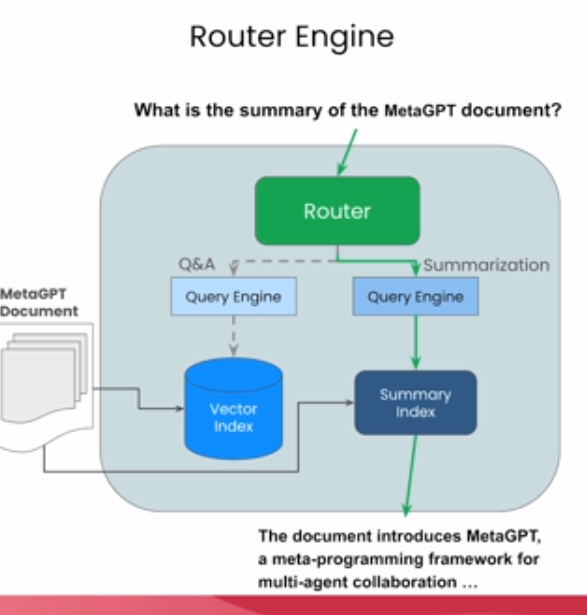

In [8]:
!wget "https://openreview.net/pdf?id=VtmBAGCN7o" -O metagpt.pdf

--2024-05-09 05:29:15--  https://openreview.net/pdf?id=VtmBAGCN7o
Resolving openreview.net (openreview.net)... 35.184.86.251
Connecting to openreview.net (openreview.net)|35.184.86.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16911937 (16M) [application/pdf]
Saving to: ‘metagpt.pdf’

metagpt.pdf         100%[===================>]  16.13M  7.58MB/s    in 2.1s    

2024-05-09 05:29:18 (7.58 MB/s) - ‘metagpt.pdf’ saved [16911937/16911937]



In [18]:
from llama_index.core import SimpleDirectoryReader

# load documents
documents = SimpleDirectoryReader(input_files=["metagpt.pdf"]).load_data()

# Define LLM and Embedding Model

In [19]:
from llama_index.core.node_parser import SentenceSplitter

splitter = SentenceSplitter(chunk_size=1024)
nodes = splitter.get_nodes_from_documents(documents)

In [33]:
from llama_index.core import Settings
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding

# Settings.llm = AzureOpenAI(model="gpt-3.5-turbo", engine)
Settings.llm = AzureOpenAI(
        # model="gt-dse-gpt-35-turbo",
        deployment_name=os.getenv('AZURE_GPT_35'),
        api_key=os.getenv('AZURE_OPENAI_API_KEY'),
        azure_endpoint=os.getenv('AZURE_OPENAI_ENDPOINT'),
        api_version=os.getenv('AZURE_OPENAI_API_VERION'),
    )


from llama_index.embeddings.openai import OpenAIEmbedding

Settings.embed_model = OpenAIEmbedding(model="text-embedding-3-large")


## Define Summary Index and Vector Index over the Same Data

In [34]:
from llama_index.core import SummaryIndex, VectorStoreIndex

summary_index = SummaryIndex(nodes)
vector_index = VectorStoreIndex(nodes)

# Define Query Engines and Set Metadata

In [36]:
summary_query_engine = summary_index.as_query_engine(
    response_mode="tree_summarize",
    use_async=True,
)
vector_query_engine = vector_index.as_query_engine()

In [37]:
from llama_index.core.tools import QueryEngineTool


summary_tool = QueryEngineTool.from_defaults(
    query_engine=summary_query_engine,
    description=(
        "Useful for summarization questions related to MetaGPT"
    ),
)

vector_tool = QueryEngineTool.from_defaults(
    query_engine=vector_query_engine,
    description=(
        "Useful for retrieving specific context from the MetaGPT paper."
    ),
)

# Define Router Query Engine

In [39]:
from llama_index.core.query_engine.router_query_engine import RouterQueryEngine
from llama_index.core.selectors import LLMSingleSelector


query_engine = RouterQueryEngine(
    selector=LLMSingleSelector.from_defaults(),
    query_engine_tools=[
        summary_tool,
        vector_tool,
    ],
    verbose=True
)

In [40]:
response = query_engine.query("What is the summary of the document?")
print(str(response))

Selecting query engine 0: The first choice mentions that it is useful for summarization questions related to MetaGPT, which directly addresses the question of what the summary of the document is..
The document introduces MetaGPT, a meta-programming framework for multi-agent collaboration based on large language models (LLMs). MetaGPT incorporates standardized operating procedures (SOPs) into prompt sequences to streamline workflows and reduce errors. It assigns diverse roles to various agents and breaks down complex tasks into subtasks. MetaGPT generates more coherent solutions than previous chat-based multi-agent systems in collaborative software engineering benchmarks. The document also discusses related work in automatic programming and LLM-based multi-agent frameworks. It concludes by summarizing the contributions of MetaGPT and its state-of-the-art performance in evaluations. Additionally, the document provides context information about the software development process, including 

In [41]:
print(len(response.source_nodes))

34


In [42]:
response = query_engine.query(
    "How do agents share information with other agents?"
)
print(str(response))

Selecting query engine 1: The question is asking about how agents share information, which is related to retrieving specific context from the MetaGPT paper..
Agents share information with other agents through a shared message pool. They publish structured messages to the message pool, which can be subscribed to by relevant agents based on their profiles. This allows agents to obtain directional information from other roles and public information from the environment. The messages stored in the memory can be checked by agents to compare them with the PRD, system design, and code files in case of errors. This communication protocol enhances role communication efficiency in the multi-agent system.


In [43]:
print(len(response.source_nodes))

2


# Let's put everything together

In [49]:
from utils import get_router_query_engine

query_engine = get_router_query_engine("metagpt.pdf", embed_model=OpenAIEmbedding(model="text-embedding-3-large"))

In [50]:
response = query_engine.query("Tell me about the ablation study results?")
print(str(response))

Selecting query engine 1: The ablation study results are specific context from the MetaGPT paper, so choice 2 is most relevant..
The ablation study results show that MetaGPT achieved an average score of 3.9, surpassing ChatDev's score of 2.1. When compared to other general intelligent algorithms like AutoGPT, which scored 1.0, MetaGPT demonstrated superior performance in generating executable code. Additionally, MetaGPT's structured messaging and feedback mechanisms not only reduced loss of communication information but also improved the execution of code when compared to ChatDev.


# L2 - Tool Calling

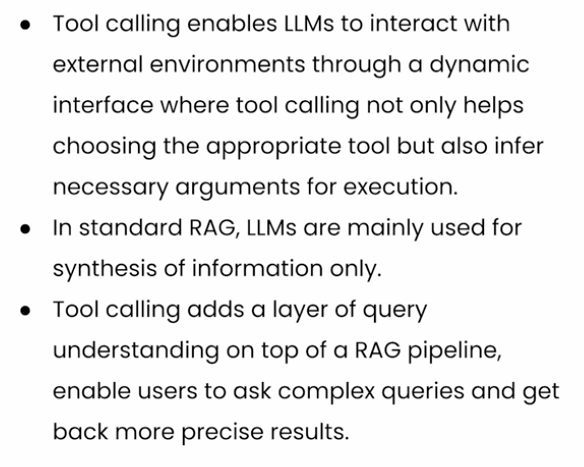

In [1]:
from helper import get_openai_api_key
OPENAI_API_KEY = get_openai_api_key()

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [4]:
from llama_index.core.tools import FunctionTool

def add(x: int, y: int) -> int:
    """Adds two integers together."""
    return x + y

def mystery(x: int, y: int) -> int: 
    """Mystery function that operates on top of two numbers."""
    return (x + y) * (x + y)


add_tool = FunctionTool.from_defaults(fn=add)
mystery_tool = FunctionTool.from_defaults(fn=mystery)

In [5]:
from llama_index.llms.openai import OpenAI

llm = OpenAI(model="gpt-3.5-turbo")
response = llm.predict_and_call(
    [add_tool, mystery_tool], 
    "Tell me the output of the mystery function on 2 and 9", 
    verbose=True
)
print(str(response))

=== Calling Function ===
Calling function: mystery with args: {"x": 2, "y": 9}
=== Function Output ===
121
121


# 2 Auto-Retrieval Tool

In [6]:
from llama_index.core import SimpleDirectoryReader
# load documents
documents = SimpleDirectoryReader(input_files=["metagpt.pdf"]).load_data()

In [7]:
from llama_index.core.node_parser import SentenceSplitter
splitter = SentenceSplitter(chunk_size=1024)
nodes = splitter.get_nodes_from_documents(documents)

In [8]:
print(nodes[0].get_content(metadata_mode="all"))

page_label: 1
file_name: metagpt.pdf
file_path: metagpt.pdf
file_type: application/pdf
file_size: 16911937
creation_date: 2024-05-09
last_modified_date: 2024-05-09

Preprint
METAGPT: M ETA PROGRAMMING FOR A
MULTI -AGENT COLLABORATIVE FRAMEWORK
Sirui Hong1∗, Mingchen Zhuge2∗, Jonathan Chen1, Xiawu Zheng3, Yuheng Cheng4,
Ceyao Zhang4,Jinlin Wang1,Zili Wang ,Steven Ka Shing Yau5,Zijuan Lin4,
Liyang Zhou6,Chenyu Ran1,Lingfeng Xiao1,7,Chenglin Wu1†,J¨urgen Schmidhuber2,8
1DeepWisdom,2AI Initiative, King Abdullah University of Science and Technology,
3Xiamen University,4The Chinese University of Hong Kong, Shenzhen,
5Nanjing University,6University of Pennsylvania,
7University of California, Berkeley,8The Swiss AI Lab IDSIA/USI/SUPSI
ABSTRACT
Remarkable progress has been made on automated problem solving through so-
cieties of agents based on large language models (LLMs). Existing LLM-based
multi-agent systems can already solve simple dialogue tasks. Solutions to more
complex tasks, however, 

In [9]:
from llama_index.core import VectorStoreIndex

vector_index = VectorStoreIndex(nodes)
query_engine = vector_index.as_query_engine(similarity_top_k=2)

In [10]:
from llama_index.core.vector_stores import MetadataFilters

query_engine = vector_index.as_query_engine(
    similarity_top_k=2,
    filters=MetadataFilters.from_dicts(
        [
            {"key": "page_label", "value": "2"}
        ]
    )
)

response = query_engine.query(
    "What are some high-level results of MetaGPT?", 
)

In [11]:
print(str(response))

Some high-level results of MetaGPT include achieving a new state-of-the-art in code generation benchmarks with 85.9% and 87.7% in Pass@1, outperforming other popular frameworks like AutoGPT, LangChain, AgentVerse, and ChatDev. Additionally, MetaGPT excels in handling higher levels of software complexity, offering extensive functionality, and demonstrating robustness and efficiency with a 100% task completion rate in experimental evaluations.


In [12]:
for n in response.source_nodes:
    print(n.metadata)

{'page_label': '2', 'file_name': 'metagpt.pdf', 'file_path': 'metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-09', 'last_modified_date': '2024-05-09'}


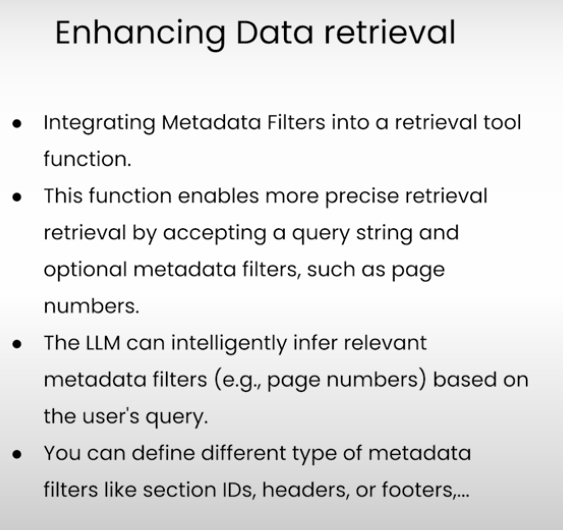

In [13]:
from typing import List
from llama_index.core.vector_stores import FilterCondition

# turning the stuff above into an actual tool to be used in function calling
def vector_query(
    query: str, 
    page_numbers: List[str]
) -> str:
    """Perform a vector search over an index.
    
    query (str): the string query to be embedded.
    page_numbers (List[str]): Filter by set of pages. Leave BLANK if we want to perform a vector search
        over all pages. Otherwise, filter by the set of specified pages.
    
    """

    metadata_dicts = [
        {"key": "page_label", "value": p} for p in page_numbers
    ]
    
    query_engine = vector_index.as_query_engine(
        similarity_top_k=2,
        filters=MetadataFilters.from_dicts(
            metadata_dicts,
            condition=FilterCondition.OR
        )
    )
    response = query_engine.query(query)
    return response
    

vector_query_tool = FunctionTool.from_defaults(
    name="vector_tool",
    fn=vector_query
)

In [14]:
llm = OpenAI(model="gpt-3.5-turbo", temperature=0)
response = llm.predict_and_call(
    [vector_query_tool], 
    "What are the high-level results of MetaGPT as described on page 2?", 
    verbose=True
)

=== Calling Function ===
Calling function: vector_tool with args: {"query": "high-level results of MetaGPT", "page_numbers": ["2"]}
=== Function Output ===
MetaGPT achieves a new state-of-the-art (SoTA) in code generation benchmarks with 85.9% and 87.7% in Pass@1. It stands out in handling higher levels of software complexity and offering extensive functionality, demonstrating robustness and efficiency in task completion.


In [15]:
for n in response.source_nodes:
    print(n.metadata)

{'page_label': '2', 'file_name': 'metagpt.pdf', 'file_path': 'metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-09', 'last_modified_date': '2024-05-09'}


### Adding other tools define previously

In [16]:
from llama_index.core import SummaryIndex
from llama_index.core.tools import QueryEngineTool

summary_index = SummaryIndex(nodes)
summary_query_engine = summary_index.as_query_engine(
    response_mode="tree_summarize",
    use_async=True,
)
summary_tool = QueryEngineTool.from_defaults(
    name="summary_tool",
    query_engine=summary_query_engine,
    description=(
        "Useful if you want to get a summary of MetaGPT"
    ),
)

In [17]:
response = llm.predict_and_call(
    [vector_query_tool, summary_tool], 
    "What are the MetaGPT comparisons with ChatDev described on page 8?", 
    verbose=True
)

=== Calling Function ===
Calling function: vector_tool with args: {"query": "MetaGPT comparisons with ChatDev", "page_numbers": ["8"]}
=== Function Output ===
MetaGPT outperforms ChatDev on the challenging SoftwareDev dataset in nearly all metrics. For example, MetaGPT achieves a higher score in executability, takes less time for software generation, uses more tokens but requires fewer tokens to generate one line of code compared to ChatDev. Additionally, MetaGPT shows better performance in code statistics and human revision cost when compared to ChatDev.


In [18]:
for n in response.source_nodes:
    print(n.metadata)

{'page_label': '8', 'file_name': 'metagpt.pdf', 'file_path': 'metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-09', 'last_modified_date': '2024-05-09'}


In [19]:
response = llm.predict_and_call(
    [vector_query_tool, summary_tool], 
    "What is a summary of the paper?", 
    verbose=True
)

=== Calling Function ===
Calling function: summary_tool with args: {"input": "Provide a summary of the paper."}
=== Function Output ===
The paper introduces MetaGPT, a meta-programming framework that enhances multi-agent systems based on Large Language Models (LLMs) by utilizing Standardized Operating Procedures (SOPs). It incorporates role specialization, structured communication interfaces, and executable feedback mechanisms to improve code generation quality during runtime. Through experiments, MetaGPT demonstrates state-of-the-art performance on various benchmarks, facilitating collaborative workflows among agents with diverse roles. The paper also discusses the development of a software application called "Drawing App" using MetaGPT, detailing the roles of different agents in designing, implementing, testing, and reviewing the software. It evaluates MetaGPT's performance in generating executable code, addresses challenges, limitations, and ethical concerns, and highlights the use 

In [20]:
for n in response.source_nodes:
    print(n.metadata)

{'page_label': '1', 'file_name': 'metagpt.pdf', 'file_path': 'metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-09', 'last_modified_date': '2024-05-09'}
{'page_label': '2', 'file_name': 'metagpt.pdf', 'file_path': 'metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-09', 'last_modified_date': '2024-05-09'}
{'page_label': '3', 'file_name': 'metagpt.pdf', 'file_path': 'metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-09', 'last_modified_date': '2024-05-09'}
{'page_label': '3', 'file_name': 'metagpt.pdf', 'file_path': 'metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-09', 'last_modified_date': '2024-05-09'}
{'page_label': '4', 'file_name': 'metagpt.pdf', 'file_path': 'metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-09', 'last_modified_date': '2024-05-09'}
{'page_lab

## L3 - Building an Agent Reasoning Loop

## Setup the query tools

In [25]:
from importlib import reload
import utils

# Reload the module to ensure changes are captured
utils = reload(utils)


In [27]:
from utils import get_doc_tools
vector_tool, summary_tool = get_doc_tools("metagpt.pdf", "metagpt")

## Setup Function Calling Agent

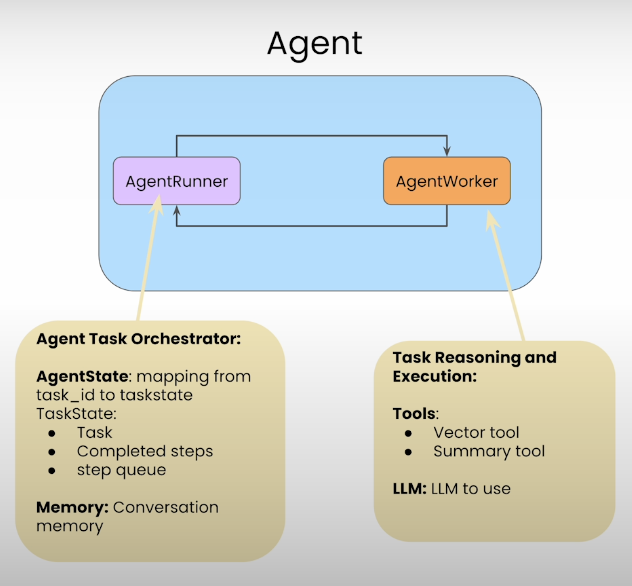

In [28]:
from llama_index.llms.openai import OpenAI

llm = OpenAI(model="gpt-3.5-turbo", temperature=0)

In [29]:
from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.core.agent import AgentRunner

agent_worker = FunctionCallingAgentWorker.from_tools(
    [vector_tool, summary_tool], 
    llm=llm, 
    verbose=True
)
agent = AgentRunner(agent_worker)

In [30]:
response = agent.query(
    "Tell me about the agent roles in MetaGPT, "
    "and then how they communicate with each other."
)

Added user message to memory: Tell me about the agent roles in MetaGPT, and then how they communicate with each other.
=== Calling Function ===
Calling function: summary_tool_metagpt with args: {"input": "agent roles in MetaGPT"}
=== Function Output ===
The agent roles in MetaGPT include the Product Manager, Architect, Project Manager, Engineer, and QA Engineer. Each role has specific responsibilities and tasks assigned to them within the collaborative framework to efficiently develop software solutions. The Product Manager focuses on generating the Product Requirement Document (PRD) and competitive analysis. The Architect is responsible for designing the system architecture and technical specifications. The Project Manager breaks down the project into tasks for execution. The Engineer develops the code based on the specifications provided. Lastly, the QA Engineer generates unit tests and ensures the quality of the software. These roles work together in a structured workflow to create 

In [31]:
print(response.source_nodes[0].get_content(metadata_mode="all"))

page_label: 1
file_name: metagpt.pdf
file_path: metagpt.pdf
file_type: application/pdf
file_size: 16911937
creation_date: 2024-05-09
last_modified_date: 2024-05-09

Preprint
METAGPT: M ETA PROGRAMMING FOR A
MULTI -AGENT COLLABORATIVE FRAMEWORK
Sirui Hong1∗, Mingchen Zhuge2∗, Jonathan Chen1, Xiawu Zheng3, Yuheng Cheng4,
Ceyao Zhang4,Jinlin Wang1,Zili Wang ,Steven Ka Shing Yau5,Zijuan Lin4,
Liyang Zhou6,Chenyu Ran1,Lingfeng Xiao1,7,Chenglin Wu1†,J¨urgen Schmidhuber2,8
1DeepWisdom,2AI Initiative, King Abdullah University of Science and Technology,
3Xiamen University,4The Chinese University of Hong Kong, Shenzhen,
5Nanjing University,6University of Pennsylvania,
7University of California, Berkeley,8The Swiss AI Lab IDSIA/USI/SUPSI
ABSTRACT
Remarkable progress has been made on automated problem solving through so-
cieties of agents based on large language models (LLMs). Existing LLM-based
multi-agent systems can already solve simple dialogue tasks. Solutions to more
complex tasks, however, 

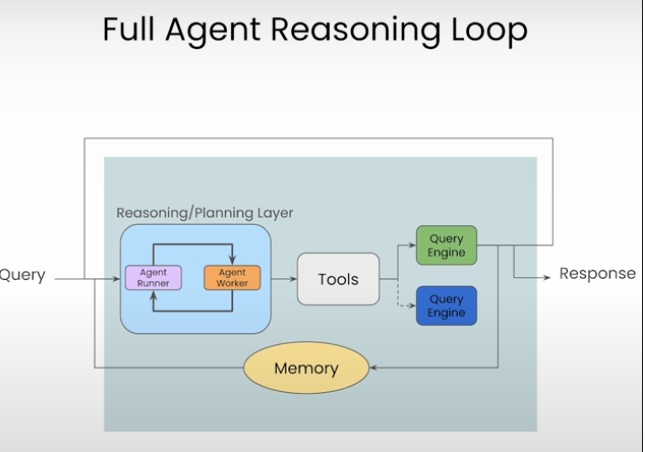

In [32]:
response = agent.chat(
    "Tell me about the evaluation datasets used."
)

Added user message to memory: Tell me about the evaluation datasets used.
=== Calling Function ===
Calling function: summary_tool_metagpt with args: {"input": "evaluation datasets used in MetaGPT"}
=== Function Output ===
The evaluation datasets used in MetaGPT include HumanEval, MBPP, and a self-generated SoftwareDev dataset. The HumanEval dataset consists of 164 handwritten programming tasks, while the MBPP dataset consists of 427 Python tasks. The SoftwareDev dataset contains 70 representative examples of software development tasks, covering diverse scopes such as mini-games, image processing algorithms, and data visualization. These datasets were utilized to evaluate the performance of MetaGPT in code generation tasks.
=== LLM Response ===
The evaluation datasets used in MetaGPT include HumanEval, MBPP, and a self-generated SoftwareDev dataset. The HumanEval dataset consists of 164 handwritten programming tasks, the MBPP dataset consists of 427 Python tasks, and the SoftwareDev dat

In [33]:
response = agent.chat("Tell me the results over one of the above datasets.")

Added user message to memory: Tell me the results over one of the above datasets.
=== Calling Function ===
Calling function: summary_tool_metagpt with args: {"input": "results over the HumanEval dataset in MetaGPT"}
=== Function Output ===
MetaGPT achieved a new state-of-the-art performance on the HumanEval dataset, surpassing previous approaches with a Pass@1 score of 85.9% and 87.7%. The experiments conducted with GPT-4 and GPT-3.5-Turbo under various conditions revealed that GPT-4 demonstrated higher sensitivity to prompts, code parsing, and post-processing results compared to GPT-3.5-Turbo. This suggests that GPT-4 performed better in returning correct completion code with the provided prompts, showcasing its effectiveness in generating code based on different settings and prompts in the programming context.
=== LLM Response ===
MetaGPT achieved a new state-of-the-art performance on the HumanEval dataset, surpassing previous approaches with a Pass@1 score of 85.9% and 87.7%. The ex

# Lower-Level: Debuggability and Control

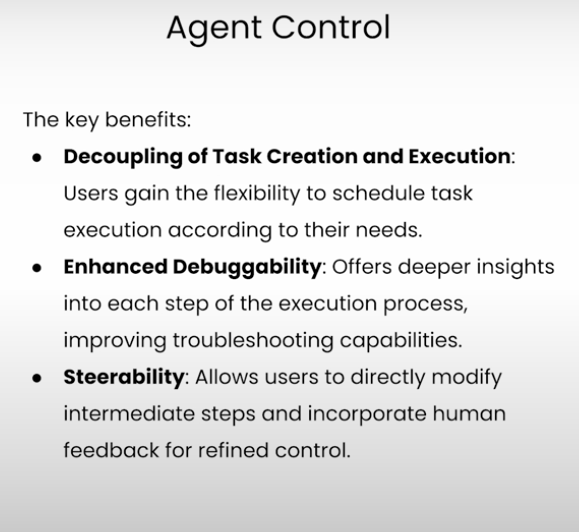

## Lower-Level: Debuggability and Control

In [34]:
agent_worker = FunctionCallingAgentWorker.from_tools(
    [vector_tool, summary_tool], 
    llm=llm, 
    verbose=True
)
agent = AgentRunner(agent_worker)

In [35]:
task = agent.create_task(
    "Tell me about the agent roles in MetaGPT, "
    "and then how they communicate with each other."
)

In [36]:
step_output = agent.run_step(task.task_id)

Added user message to memory: Tell me about the agent roles in MetaGPT, and then how they communicate with each other.
=== Calling Function ===
Calling function: summary_tool_metagpt with args: {"input": "agent roles in MetaGPT"}
=== Function Output ===
The agent roles in MetaGPT include the Product Manager, Architect, Project Manager, Engineers, and QA Engineer. The Product Manager is responsible for creating the Product Requirement Document (PRD). The Architect designs the system architecture. The Project Manager breaks down tasks and assigns them to Engineers. Engineers develop the code based on specifications. The QA Engineer generates unit test code and ensures high-quality software. Each role contributes significantly to the collaborative software development process within the MetaGPT framework.


In [37]:
completed_steps = agent.get_completed_steps(task.task_id)
print(f"Num completed for task {task.task_id}: {len(completed_steps)}")
print(completed_steps[0].output.sources[0].raw_output)

Num completed for task 561d2282-b5a2-478f-b08c-dfacf975817f: 1
The agent roles in MetaGPT include the Product Manager, Architect, Project Manager, Engineers, and QA Engineer. The Product Manager is responsible for creating the Product Requirement Document (PRD). The Architect designs the system architecture. The Project Manager breaks down tasks and assigns them to Engineers. Engineers develop the code based on specifications. The QA Engineer generates unit test code and ensures high-quality software. Each role contributes significantly to the collaborative software development process within the MetaGPT framework.


In [38]:
upcoming_steps = agent.get_upcoming_steps(task.task_id)
print(f"Num upcoming steps for task {task.task_id}: {len(upcoming_steps)}")
upcoming_steps[0]

Num upcoming steps for task 561d2282-b5a2-478f-b08c-dfacf975817f: 1


TaskStep(task_id='561d2282-b5a2-478f-b08c-dfacf975817f', step_id='343d2626-0fb7-4b50-aba7-b2cfa666f709', input=None, step_state={}, next_steps={}, prev_steps={}, is_ready=True)

In [39]:
step_output = agent.run_step(
    task.task_id, input="What about how agents share information?"
)

Added user message to memory: What about how agents share information?
=== Calling Function ===
Calling function: summary_tool_metagpt with args: {"input": "how agents share information in MetaGPT"}
=== Function Output ===
Agents in MetaGPT share information through a shared message pool where they publish structured messages and subscribe to relevant messages based on their profiles. This shared message pool allows all agents to exchange messages directly, enhancing communication efficiency. Additionally, agents utilize a subscription mechanism to extract relevant information based on their role profiles, ensuring that they receive only task-related information and avoid distractions from irrelevant details. This structured communication approach helps in efficient collaboration among the agents in MetaGPT.


In [40]:
step_output = agent.run_step(task.task_id)
print(step_output.is_last)

=== LLM Response ===
Agents in MetaGPT share information through a shared message pool where they publish structured messages and subscribe to relevant messages based on their profiles. This shared message pool allows all agents to exchange messages directly, enhancing communication efficiency. Additionally, agents utilize a subscription mechanism to extract relevant information based on their role profiles, ensuring that they receive only task-related information and avoid distractions from irrelevant details. This structured communication approach helps in efficient collaboration among the agents in MetaGPT.
True


In [41]:
response = agent.finalize_response(task.task_id)

In [42]:
print(str(response))

assistant: Agents in MetaGPT share information through a shared message pool where they publish structured messages and subscribe to relevant messages based on their profiles. This shared message pool allows all agents to exchange messages directly, enhancing communication efficiency. Additionally, agents utilize a subscription mechanism to extract relevant information based on their role profiles, ensuring that they receive only task-related information and avoid distractions from irrelevant details. This structured communication approach helps in efficient collaboration among the agents in MetaGPT.


## Lesson 4 - Building Multi-Document Agent
- https://learn.deeplearning.ai/courses/building-agentic-rag-with-llamaindex/lesson/5/building-a-multi-document-agent

Refer to the above to get the PDF files 

In [1]:
from helper import get_openai_api_key
OPENAI_API_KEY = get_openai_api_key()

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
## 1. Setup an agent over 3 papers

# **Note**: The pdf files are included with this lesson. To access these papers, go to the `File` menu and select`Open...`.

urls = [
    "https://openreview.net/pdf?id=VtmBAGCN7o",
    "https://openreview.net/pdf?id=6PmJoRfdaK",
    "https://openreview.net/pdf?id=hSyW5go0v8",
]

papers = [
    "metagpt.pdf",
    "longlora.pdf",
    "selfrag.pdf",
]

from utils import get_doc_tools
from pathlib import Path

paper_to_tools_dict = {}
for paper in papers:
    print(f"Getting tools for paper: {paper}")
    vector_tool, summary_tool = get_doc_tools(paper, Path(paper).stem)
    paper_to_tools_dict[paper] = [vector_tool, summary_tool]

initial_tools = [t for paper in papers for t in paper_to_tools_dict[paper]]

from llama_index.llms.openai import OpenAI

llm = OpenAI(model="gpt-3.5-turbo")

len(initial_tools)

from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.core.agent import AgentRunner

agent_worker = FunctionCallingAgentWorker.from_tools(
    initial_tools, 
    llm=llm, 
    verbose=True
)
agent = AgentRunner(agent_worker)

response = agent.query(
    "Tell me about the evaluation dataset used in LongLoRA, "
    "and then tell me about the evaluation results"
)

response = agent.query("Give me a summary of both Self-RAG and LongLoRA")
print(str(response))

Getting tools for paper: metagpt.pdf
Getting tools for paper: longlora.pdf


ValueError: File longlora.pdf does not exist.

In [ ]:




## 2. Setup an agent over 11 papers

### Download 11 ICLR papers

urls = [
    "https://openreview.net/pdf?id=VtmBAGCN7o",
    "https://openreview.net/pdf?id=6PmJoRfdaK",
    "https://openreview.net/pdf?id=LzPWWPAdY4",
    "https://openreview.net/pdf?id=VTF8yNQM66",
    "https://openreview.net/pdf?id=hSyW5go0v8",
    "https://openreview.net/pdf?id=9WD9KwssyT",
    "https://openreview.net/pdf?id=yV6fD7LYkF",
    "https://openreview.net/pdf?id=hnrB5YHoYu",
    "https://openreview.net/pdf?id=WbWtOYIzIK",
    "https://openreview.net/pdf?id=c5pwL0Soay",
    "https://openreview.net/pdf?id=TpD2aG1h0D"
]

papers = [
    "metagpt.pdf",
    "longlora.pdf",
    "loftq.pdf",
    "swebench.pdf",
    "selfrag.pdf",
    "zipformer.pdf",
    "values.pdf",
    "finetune_fair_diffusion.pdf",
    "knowledge_card.pdf",
    "metra.pdf",
    "vr_mcl.pdf"
]

# To download these papers, below is the needed code:


    #for url, paper in zip(urls, papers):
         #!wget "{url}" -O "{paper}"
    
    
**Note**: The pdf files are included with this lesson. To access these papers, go to the `File` menu and select`Open...`.

from utils import get_doc_tools
from pathlib import Path

paper_to_tools_dict = {}
for paper in papers:
    print(f"Getting tools for paper: {paper}")
    vector_tool, summary_tool = get_doc_tools(paper, Path(paper).stem)
    paper_to_tools_dict[paper] = [vector_tool, summary_tool]

### Extend the Agent with Tool Retrieval

all_tools = [t for paper in papers for t in paper_to_tools_dict[paper]]

# define an "object" index and retriever over these tools
from llama_index.core import VectorStoreIndex
from llama_index.core.objects import ObjectIndex

obj_index = ObjectIndex.from_objects(
    all_tools,
    index_cls=VectorStoreIndex,
)

obj_retriever = obj_index.as_retriever(similarity_top_k=3)

tools = obj_retriever.retrieve(
    "Tell me about the eval dataset used in MetaGPT and SWE-Bench"
)

tools[2].metadata

from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.core.agent import AgentRunner

agent_worker = FunctionCallingAgentWorker.from_tools(
    tool_retriever=obj_retriever,
    llm=llm, 
    system_prompt=""" \
You are an agent designed to answer queries over a set of given papers.
Please always use the tools provided to answer a question. Do not rely on prior knowledge.\

""",
    verbose=True
)
agent = AgentRunner(agent_worker)

response = agent.query(
    "Tell me about the evaluation dataset used "
    "in MetaGPT and compare it against SWE-Bench"
)
print(str(response))

response = agent.query(
    "Compare and contrast the LoRA papers (LongLoRA, LoftQ). "
    "Analyze the approach in each paper first. "
)